This is the notebook to build up basic CNN model and use the cat and dog image provided by the Microsoft to test it.

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = True

## pre-processing step

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat" # give the directory of images
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}  
    training_data = []
    catcount = 0
    dogcount = 0 # make sure the "balance"
    
    def make_training_data(self):
        for label in self.LABELS: #iterate the directory
            print(label)
            for f in tqdm(os.listdir(label)):  # iterate all the image within the directory, f -> the file name
                try:
                    path = os.path.join(label, f) # get the full path to the image
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # convert the iimage to gray scale (optional)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

PetImages/Cat


100%|███████████████████████████████████████████████████████████████████████████| 12501/12501 [00:13<00:00, 935.79it/s]


PetImages/Dog


100%|███████████████████████████████████████████████████████████████████████████| 12501/12501 [00:14<00:00, 870.25it/s]


Cats: 12476
Dogs: 12470


In [5]:
training_data = np.load("training_data.npy", allow_pickle = True)

In [6]:
print(len(training_data))

24946


In [7]:
for i in range(4):
    print(training_data[i])

[array([[180, 186, 187, ...,  38,  56,  86],
       [171, 168, 162, ..., 111,  75,  77],
       [127, 150, 164, ...,  67,  57,  77],
       ...,
       [ 47,  53,  54, ...,  96,  83,  65],
       [ 35,  43,  53, ...,  80,  90, 101],
       [ 37,  37,  41, ...,  75,  61, 111]], dtype=uint8)
 array([0., 1.])]
[array([[  4,   6,   9, ...,   0,   0,   0],
       [  5,   8,   8, ...,   4,   0,   0],
       [  5,   9,  10, ...,   2,   0,   0],
       ...,
       [ 34,  62,  69, ...,  52,  44, 142],
       [ 50,  60,  66, ...,  78,  70, 136],
       [  7,  55,  60, ...,  77,  73, 108]], dtype=uint8)
 array([1., 0.])]
[array([[ 35,  35,  34, ...,  41,  42,  41],
       [ 35,  34,  35, ...,  41,  40,  40],
       [ 34,  36,  34, ...,  40,  40,  41],
       ...,
       [245, 243, 239, ..., 250, 247, 248],
       [247, 248, 244, ..., 248, 250, 248],
       [245, 248, 249, ..., 255, 255, 255]], dtype=uint8)
 array([1., 0.])]
[array([[191, 138, 152, ..., 205, 173, 155],
       [212, 192, 123, ..., 

In [8]:
import matplotlib.pyplot as plt


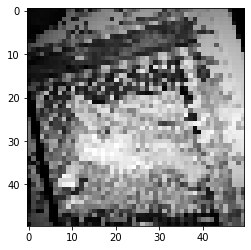

In [9]:
plt.imshow(training_data[1][0], cmap="gray")
plt.show()

In [10]:
print(training_data[1])

[array([[  4,   6,   9, ...,   0,   0,   0],
       [  5,   8,   8, ...,   4,   0,   0],
       [  5,   9,  10, ...,   2,   0,   0],
       ...,
       [ 34,  62,  69, ...,  52,  44, 142],
       [ 50,  60,  66, ...,  78,  70, 136],
       [  7,  55,  60, ...,  77,  73, 108]], dtype=uint8)
 array([1., 0.])]


In [11]:
for i in range(5):
    print(training_data[i][1])

[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]


In [12]:
training_data[1][0]

array([[  4,   6,   9, ...,   0,   0,   0],
       [  5,   8,   8, ...,   4,   0,   0],
       [  5,   9,  10, ...,   2,   0,   0],
       ...,
       [ 34,  62,  69, ...,  52,  44, 142],
       [ 50,  60,  66, ...,  78,  70, 136],
       [  7,  55,  60, ...,  77,  73, 108]], dtype=uint8)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Making layers
        self.conv1 = nn.Conv2d(1, 32, 5) # 1st layer
        # 5 -> kernel size, which means that it will form a 5 by 5 window 
        # to roll over the data to find features
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50, 50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        # Eventually output to at least one linear layer
        # self.fc1 = nn.Linear(???, 512)
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)        
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        #print(x[0].shape)
        
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # flatten
        x = F.relu(self.fc1(x)) # put into the first fully connected layer
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
net = Net()    

In [15]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0  # scaling the imagery which means that turn the pixel values form (0~255) to (0~1)
y = torch.Tensor([i[1] for i in training_data])

# Separate the training ant testing data
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)


2494


In [16]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [17]:
BATCH_SIZE = 100
EPOCHS = 3

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # tqdm -> show the progress bar
        #print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)
        

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [01:32<00:00,  2.42it/s]


tensor(0.1412, grad_fn=<MseLossBackward>)


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
            
        total += 1
        
print("Accuracy:", round(correct/total,3))

100%|█████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:09<00:00, 256.87it/s]


Accuracy: 0.721


In [48]:
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss
    

In [46]:
def test(size=32):    
    randsom_start = np.random.randint(len(test_X)-size)
    #X, y = text_X[:size], test_y[:size]
    X, y =test_X[randsom_start:randsom_start+size], test_y[randsom_start:randsom_start+size] 
    # slice start from random point
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50), y)
    return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)

0.6875 tensor(0.2046)


In [52]:
import time

MODEL_NAME = f"model-{int(time.time())}"

net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
    BATCH_SIZE = 100
    EPOCHS = 4
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
                batch_y = train_y[i:i+BATCH_SIZE]
                
                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                if i % 50 == 0: 
                    val_acc, val_loss = test(size=32)
                    f.write(f"{MODEL_NAME}, {round(time.time(),3)}, {round(float(acc),2)}, {round(float(loss),4)}, {round(float(val_acc),2)}, {round(float(val_loss),4)}\n")
                    
train()                

model-1583585312


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [01:48<00:00,  2.07it/s]
